In [1]:
from pandas_datareader import data
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
start='2001-01-01'
end='2020-01-01'
user_input=input("Stock Name:")
df = data.DataReader(user_input,'yahoo',start,end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-11-27,207.000000,154.000000,154.000000,191.800003,27262365.0,177.675140
2007-11-28,197.800003,174.929993,194.000000,177.000000,21958915.0,163.965103
2007-11-29,182.800003,168.460007,181.000000,177.399994,25616715.0,164.335632
2007-11-30,191.399994,178.000000,178.000000,185.800003,23047035.0,172.116989
2007-12-03,198.860001,184.399994,187.949997,196.000000,14578850.0,181.565811


In [3]:
df=df.reset_index()
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2007-11-27,207.000000,154.000000,154.000000,191.800003,27262365.0,177.675140
1,2007-11-28,197.800003,174.929993,194.000000,177.000000,21958915.0,163.965103
2,2007-11-29,182.800003,168.460007,181.000000,177.399994,25616715.0,164.335632
3,2007-11-30,191.399994,178.000000,178.000000,185.800003,23047035.0,172.116989
4,2007-12-03,198.860001,184.399994,187.949997,196.000000,14578850.0,181.565811


In [4]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2975.000000,2975.000000,2975.000000,2975.000000,2.975000e+03,2975.000000
mean,227.838044,219.826259,224.044897,223.715536,2.892930e+06,215.924655
std,108.889224,106.710059,108.027073,107.883875,3.051564e+06,107.171310
min,52.509998,50.730000,51.400002,51.590000,0.000000e+00,47.914719
25%,137.399994,131.224998,134.974998,134.699997,1.229062e+06,127.339027
50%,174.699997,166.000000,170.000000,170.100006,2.194030e+06,160.389297
75%,331.649994,320.549988,326.100006,325.650009,3.573876e+06,316.826401
max,452.350006,434.799988,450.000000,448.750000,6.260449e+07,438.315674


**Data Exploration**

Here you will print the data you collected in to the DataFrame. You should also make sure that the data is sorted by date, because the order of the data is crucial in time series modelling.

In [5]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2007-11-27,207.000000,154.000000,154.000000,191.800003,27262365.0,177.675140
1,2007-11-28,197.800003,174.929993,194.000000,177.000000,21958915.0,163.965103
2,2007-11-29,182.800003,168.460007,181.000000,177.399994,25616715.0,164.335632
3,2007-11-30,191.399994,178.000000,178.000000,185.800003,23047035.0,172.116989
4,2007-12-03,198.860001,184.399994,187.949997,196.000000,14578850.0,181.565811


**Data Visualization**

Now let's see what sort of data you have. You want data with various patterns occurring over time.

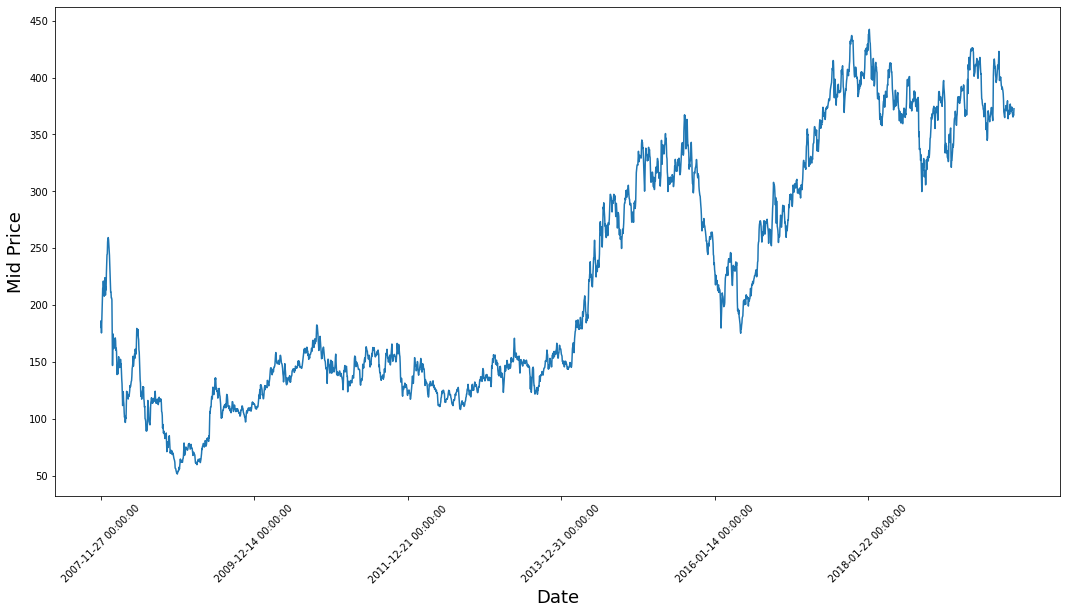

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

**We can also use a probability distribution to visualize the data in our series.**

<AxesSubplot:ylabel='Density'>

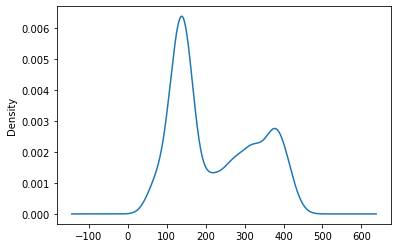

In [7]:
#Distribution of the dataset
df_mid = (df['Low']+df['High'])/2.0
df_mid.plot(kind='kde')

**Splitting Data into a Training set and a Test set**

We will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day.

**ADF (Augmented Dickey-Fuller) Test**

One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

**Null Hypothesis**: The series has a unit root (value of a =1)

**Alternate Hypothesis**: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

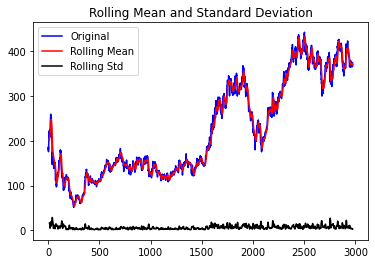

Results of dickey fuller test
Test Statistics                  -0.881994
p-value                           0.793844
No. of lags used                 13.000000
Number of observations used    2961.000000
critical value (1%)              -3.432560
critical value (5%)              -2.862517
critical value (10%)             -2.567290
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_mid)

The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

Let’s isolate the time series from the Trend and Seasonality.

<Figure size 432x288 with 0 Axes>

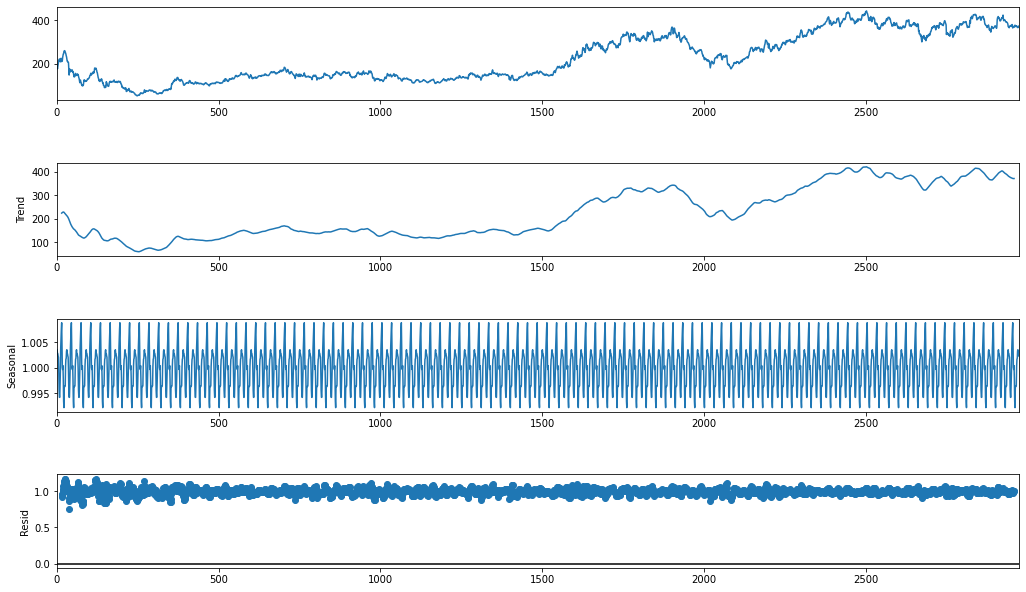

In [23]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_mid, model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [9]:
# First calculate the mid prices from the highest and lowest
high_prices = np.asarray(df.loc[:,'High'])
low_prices = np.asarray(df.loc[:,'Low'])
mid_prices = (high_prices+low_prices)/2.0

In [10]:
df['Mid Value']=mid_prices.tolist()
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Mid Value
0,2007-11-27,207.000000,154.000000,154.000000,191.800003,27262365.0,177.675140,180.500000
1,2007-11-28,197.800003,174.929993,194.000000,177.000000,21958915.0,163.965103,186.364998
2,2007-11-29,182.800003,168.460007,181.000000,177.399994,25616715.0,164.335632,175.630005
3,2007-11-30,191.399994,178.000000,178.000000,185.800003,23047035.0,172.116989,184.699997
4,2007-12-03,198.860001,184.399994,187.949997,196.000000,14578850.0,181.565811,191.629997


In [11]:
train_data=pd.DataFrame(df['Mid Value'][0:int(len(df)*0.70)])
test_data=pd.DataFrame(df['Mid Value'][int(len(df)*0.70):int(len(df))])

print(train_data.shape)
print(test_data.shape)

(2082, 1)
(893, 1)


**Normalizing the Data**

Now you need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape [data_size, num_features].

In [12]:
# Scale the data to be between 0 and 1
# When scaling remember!We normalize both test and train data with respect to training data
# Because we are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = np.asarray(train_data).reshape(-1,1)
test_data = np.asarray(test_data).reshape(-1,1)

In [13]:
# Train the Scaler with training data and smooth data
smoothing_window_size =int(input("smoothing_window_size:"))
for di in range(0,train_data.shape[0]-int(train_data.shape[0]/10),smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape the data back to the shape of [data_size]

In [14]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

You can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that you should only smooth training data.

In [15]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(train_data.shape[0]):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

**Standard Average**

You can understand the difficulty of this problem by first trying to model this as an average calculation problem. First you will try to predict the future stock market prices (for example, xt+1 ) as an average of the previously observed stock market prices within a fixed size window (for example, xt-N, ..., xt) (say previous 100 days). Thereafter you will try a bit more fancier "exponential moving average" method and see how well that does. Then you will move on to the "holy-grail" of time-series prediction; Long Short-Term Memory models.

**X(t+1)=1/N*submission(Xi) for i=t-N to t**

In other words, you say the prediction at t+1 is the average value of all the stock prices you observed within a window of t to t−N.

In [16]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(df[pred_idx:'Date'], '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01006


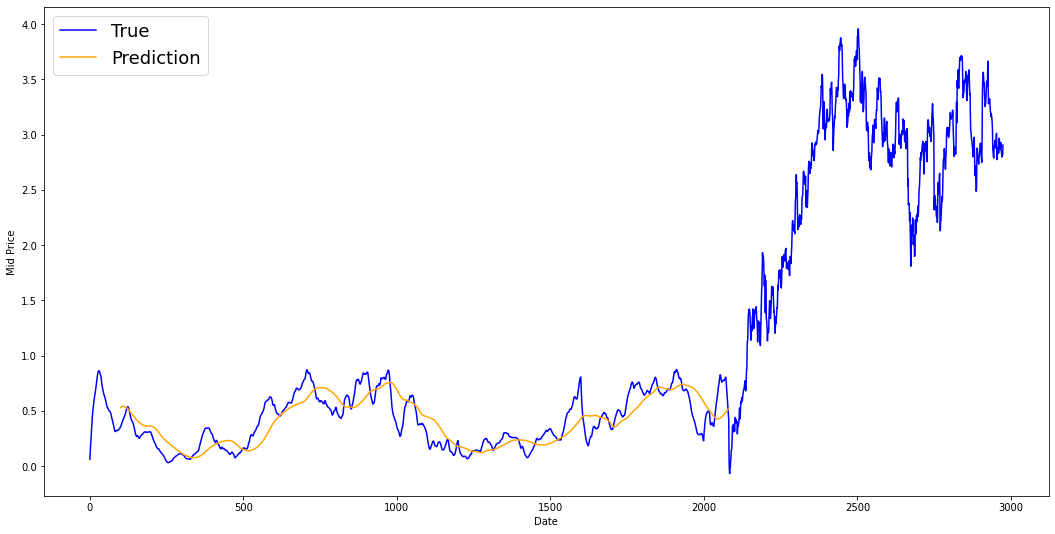

In [17]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()